Forecasting antidiabetic drug prescriptions

The objective is to forecast the number of antidiabetic drug prescriptions in Australia from '91 to 2008. This would allow us to gauge the production of these drugs to meet the demand and avoid overproduction, in a professional setting. This data was recorded by the Australian Health Insurance Commission.

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union



import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

%matplotlib inline 





In [2]:
df = pd.read_csv(r"C:\Users\user\Downloads\AusAntidiabeticDrug.csv")
df.shape 

(204, 2)

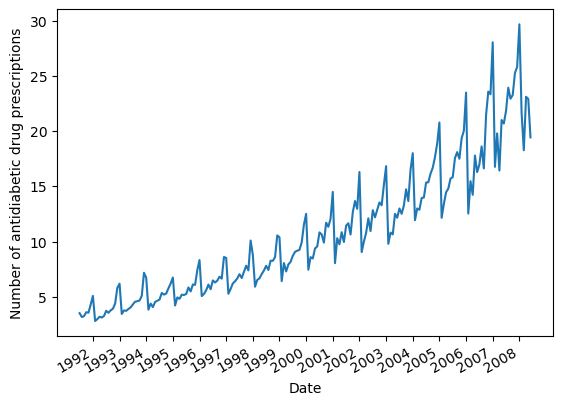

In [3]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of antidiabetic drug prescriptions')

plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))

fig.autofmt_xdate()
plt.show()

Perform decomposition to visualize the trend, seasonality and residual components of the time series.

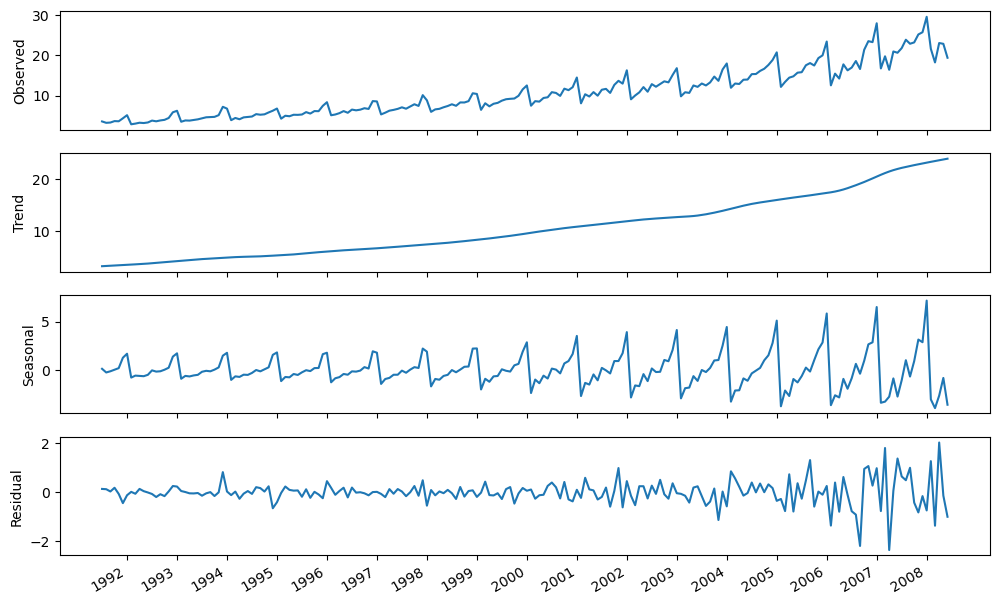

In [4]:
decomposition = STL(df.y, period=12).fit() #set the period to 12 since we have monthly data. Col y has the prescriptions

fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(12,8), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')

plt.xticks(np.arange(6,203,12), np.arange(1992,2009,1))

fig.autofmt_xdate()
plt.show()



From these graphs we note the following:
1. We do not have any exogenous variables to work with, so the SARIMAX model would not be ideal

2. We have a trend as well as seasonality.

3. We wish to predict only one target, a VAR model is not relevant. A SARIMA(p,d,q)(P,D,Q)m model would be the optimal solution. 

In [5]:
#determine if the series is stationary 

ad_fuller_result = adfuller(df.y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value : {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306736
p-value : 1.0


In [6]:
#apply transformation since the series is not stationary 
y_diff = np.diff(df.y, n=1)

ad_fuller_result= adfuller(y_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value : {ad_fuller_result[1]}')


ADF Statistic: -2.4951721474496935
p-value : 0.1166534168646991


P-value is still greater than 0.05 meaning we canot reject the null hypotheisis that the series is not stationary. We do a seasonal differencing. Having monthly data means our m=12. Seasonal diff subtracts values that are 12 timeteps apart:

In [7]:
y_diff_seasonal_diff = np.diff(y_diff, n=12)

ad_fuller_result= adfuller(y_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value : {ad_fuller_result[1]}')

ADF Statistic: -19.848440096240907
p-value : 0.0


We differenced the series once and took one seasonal difference thus, d=1, D=1, and m=12. Our final model should SARIMA(p,1,q)(P,1,Q)12 model.

Model Selection

In [8]:
train = df.y[:168] #training set has 168 observations
test = df.y[168:] #test set has 36 observations, the last 36 months

print(len(test))

36


write a function to optimize the SARIMAX model, find the values of p, d, q, P, D, Q, that minimize the Akaike Information Criterion (AIC)

In [9]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d:int, D:int, s: int) -> pd.DataFrame:
    results = [] #list to store results

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3],s),
                simple_differencing=False).fit(disp=False)

        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [11]:
ps = range(0,5,1)
qs = range(0,5,1)
Ps = range(0,5,1)
Qs = range(0,5,1)

order_list = list(product(ps,qs,Ps,Qs))

d=1
D=1
s=12

In [12]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list,d,D,s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951097
1,"(2, 4, 1, 3)",271.214064
2,"(3, 3, 1, 3)",271.446963
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.222797
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


The orders that give the lowest AIC are: p=3, q=1,P=1, Q=3 thus our best model is SARIMA(3,1,1)(1,1,3)12. We then analyze the residuals of this model to see if they are white noise.

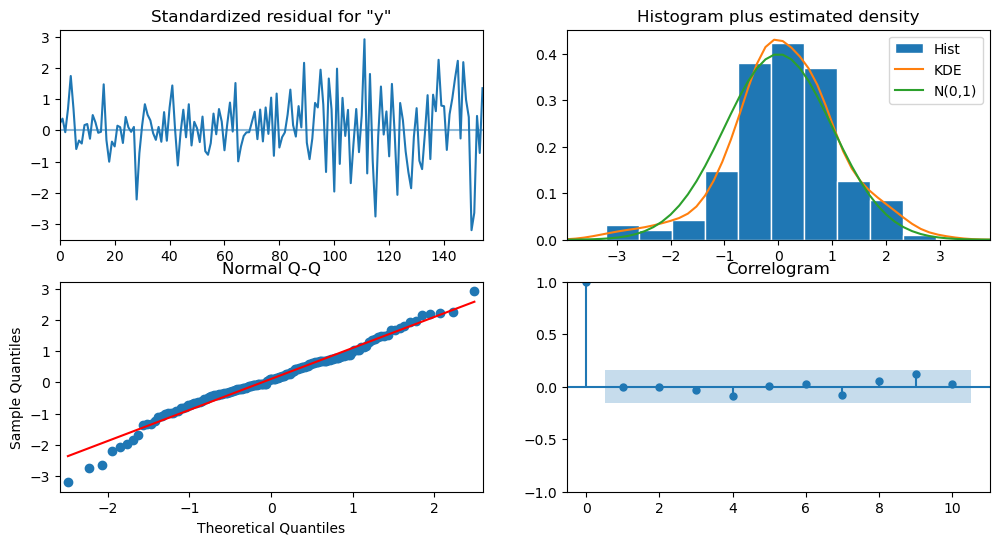

In [15]:
SARIMA_model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False).fit(disp=False)

SARIMA_model.plot_diagnostics(figsize=(12, 6))

plt.show()

#this qualitatively analyses the model fit and its residuals 

In [27]:
residuals = SARIMA_model.resid

#use acorr_ljungbox to determine if the residuals are white noise

print(acorr_ljungbox(residuals, lags=12, boxpierce=False))

#pvalue is greater than 0.05 thus we accept the null hypothesis that the residuals are white noise

      lb_stat  lb_pvalue
1    0.436941   0.508603
2    0.627787   0.730597
3    0.646287   0.885759
4    2.258741   0.688291
5    2.951037   0.707534
6    3.390065   0.758534
7    9.982768   0.189552
8   10.592802   0.225856
9   11.855091   0.221602
10  11.986379   0.285969
11  12.687656   0.314229
12  13.270796   0.349669


Forecasting and Evaluating the Model

We will perform rolling forecasts of 12 months over the test set of 36 months. We'll use the naive seasonal forecasting as a baseline, it will take the lat 12 months of data and use them as forecast for the next 12 months. 

First we define the rolling function to generatethe predicitons over the entire test set with a window of 12 months.

In [31]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [32]:
#create a copy of the test set to hold the predictions as well as the actual values

pred_df = df[168:] 
pred_df 

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


Let's define the parameters to beused. Considering the dataset has 204 rows, the training set is 204-36 = 168. Since our test set has 36 months, we set the horizon to 36. Thus, the rolling forecast will generate 36 predictions. We'll use the last season method as a baseline. The window is set to 12 months, since we ae forecasting 12 months at a time. 

In [33]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [34]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.749492
169,2005-08-01,17.554701,15.370764,16.685292
170,2005-09-01,18.100864,16.142005,17.189281
171,2005-10-01,17.496668,16.685754,18.089305
172,2005-11-01,19.347265,17.636728,18.657933
173,2005-12-01,20.031291,18.869325,19.949889
174,2006-01-01,23.486694,20.778723,22.075517
175,2006-02-01,12.536987,12.154552,13.745818
176,2006-03-01,15.467018,13.402392,15.087051
177,2006-04-01,14.233539,14.459239,15.657888


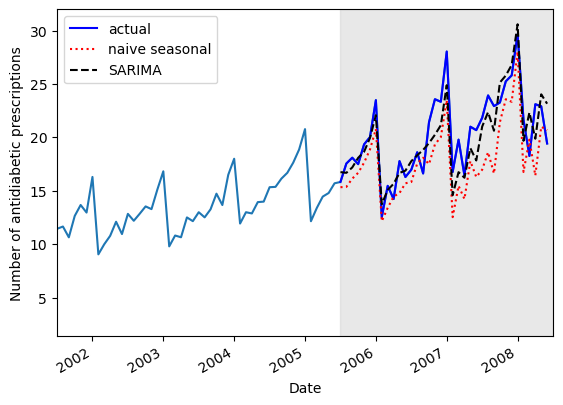

In [37]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of antidiabetic prescriptions')
ax.axvspan(168, 204, alpha=0.5, color='lightgrey')

ax.legend(loc=2) # upper left corner

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1)) #limit x-axis so we can zoom in on the test period 
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.show()

SARIMA has a better fit than the naive seasonal method. We can evaluate the performance of the model using MAPE(mean absolute percentage error).

In [44]:
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/y_true) * 100

mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.897114644169526


mape for naive seasonal is 12.69% while for SARIMA is 7.90%. We can plot this in a bar chart:

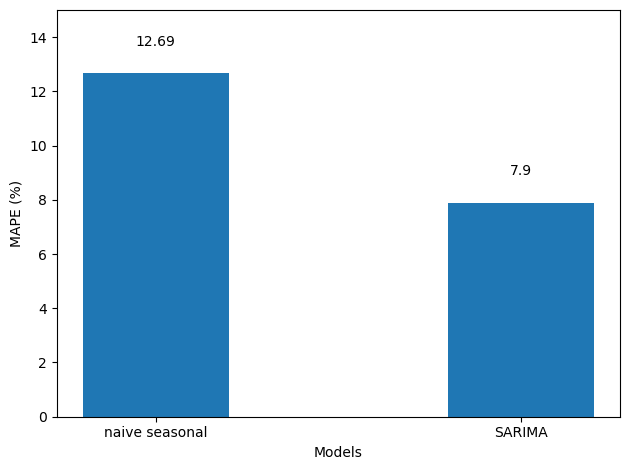

In [45]:
fig, ax = plt.subplots()
x = ['naive seasonal', 'SARIMA']
y = [mape_naive_seasonal, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
plt.tight_layout()


SARIMA model achieves the lowest MAPE of 7.90% therefore we conclude that SARIMA(2,1,3)(1,1,3,12) is the best model to use to forecast number of monthly antidiabetic drug prescriptions. 